In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sys
import os
sys.path.append('../src/')

from data_utils import *

In [2]:
def draw_point_cloud(ax, points, axes=[0, 1, 2], point_size=0.1, xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        # 限制範圍 ROI
        axes_limits = [
            [-20, 80], # X axis range
            [-20, 20], # Y axis range
            [-3, 3]   # Z axis range
        ]
        axes_str = ['X', 'Y', 'Z']
        ax.grid(False)
        
        ax.scatter(*np.transpose(points[:, axes]), s=point_size, c=points[:, 3], cmap='gray')
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)

In [3]:
DATA_PATH = '/home/sean/Documents/KITTI/2011_09_26_drive_0005_sync'

points = read_point_cloud(os.path.join(DATA_PATH, 'velodyne_points/data/%010d.bin'%0))

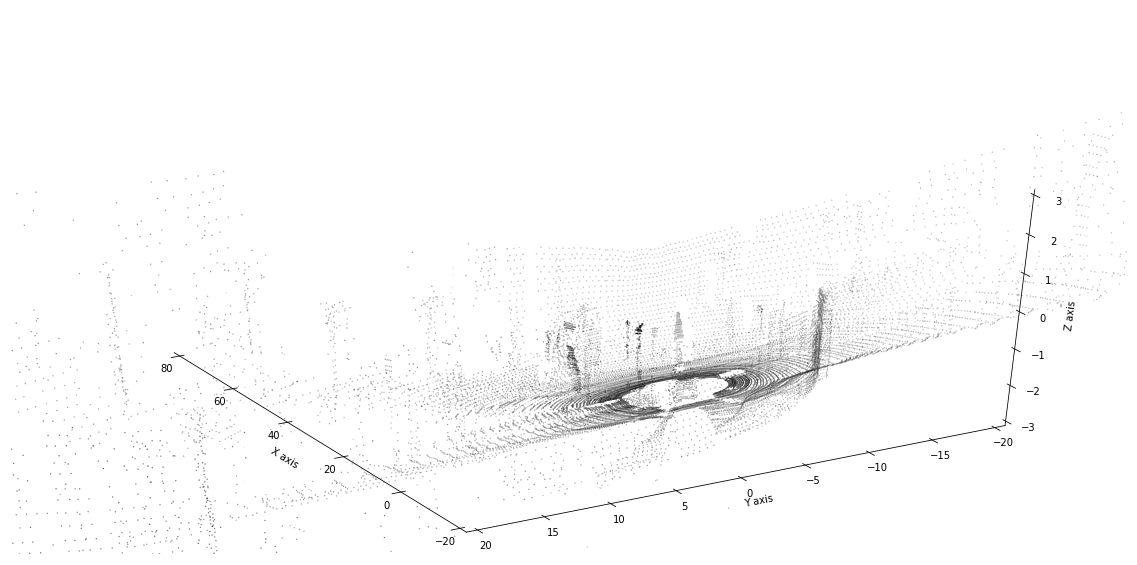

In [4]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, 150)
draw_point_cloud(ax, points[::5])
#draw_point_cloud(ax, points)

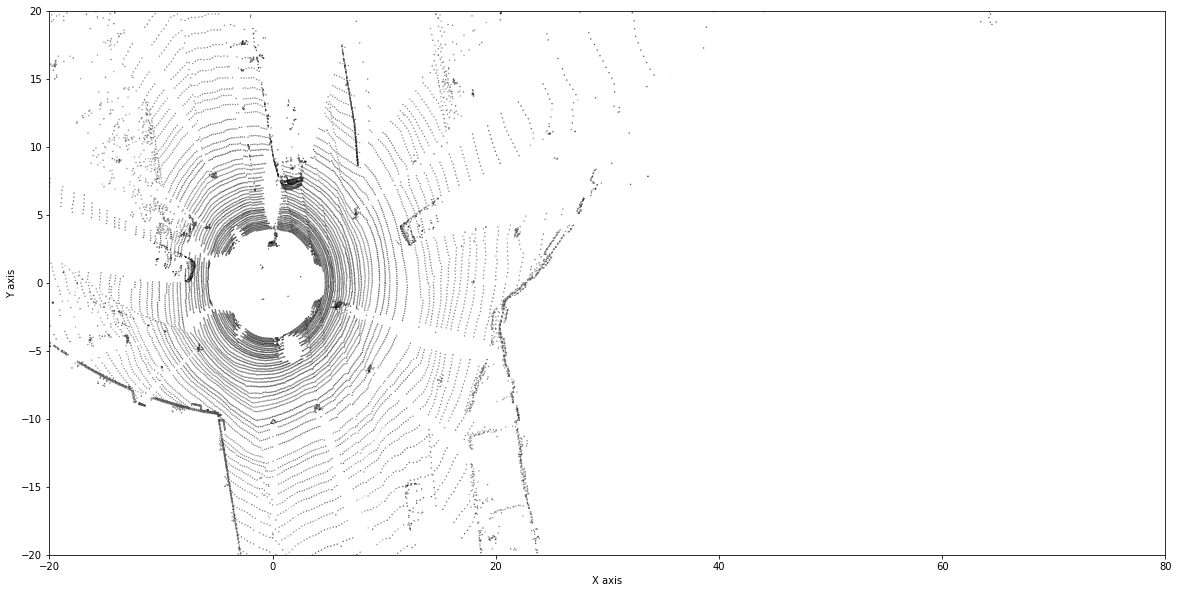

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
draw_point_cloud(ax, points[::5], axes=[0, 1])
#draw_point_cloud(ax, points[::5], axes=[1, 2])

In [6]:
df_tracking = read_tracking('/home/sean/Documents/KITTI/training/label_02/0000.txt')
df_tracking.head()

,frame,track_id,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,height,width,length,pos_x,pos_y,pos_z,rot_y
2,0,0,Car,0,0,-1.793451,296.744956,161.752147,455.226042,292.372804,2.000000,1.823255,4.433886,-4.552284,1.858523,13.410495,-2.115488
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245
7,1,0,Car,0,0,-1.796862,294.898777,156.024256,452.199718,284.621269,2.000000,1.823255,4.433886,-4.650955,1.766774,13.581085,-2.121565
8,1,1,Cyclist,0,0,-1.935205,745.017137,156.393157,938.839722,374.000000,1.739063,0.824591,1.785241,1.700640,1.640419,5.778596,-1.664456


In [7]:
def compute_3d_box_cam2(h, w, l, x, y, z, yaw):
    """
    Return : 3xn(8) in cam2 coordinate
    """
    # R 是旋轉矩陣(此為繞y軸旋轉)
    R = np.array([[np.cos(yaw), 0, np.sin(yaw)],[0, 1, 0], [-np.sin(yaw), 0,np.cos(yaw)]])
    # 參考 https://github.com/pratikac/kitti/blob/master/readme.tracking.txt
    x_corners = [l/2, l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2]
    y_corners = [0,   0,    0,    0,   -h,   -h,   -h,   -h  ]
    z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2  ]
    corners_3d_cam2 = np.dot(R, np.vstack([x_corners, y_corners, z_corners]))
    corners_3d_cam2 += np.vstack([x, y, z])
    return corners_3d_cam2

In [8]:
def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

In [9]:
corners_3d_cam2 = compute_3d_box_cam2(*df_tracking.loc[2, ['height', 'width', 'length',
                                                           'pos_x', 'pos_y', 'pos_z','rot_y']])

In [10]:
corners_3d_cam2.shape

(3, 8)

In [11]:
corners_3d_cam2

array([[-6.48070602, -4.92129955, -2.62386198, -4.18326845, -6.48070602,
        -4.92129955, -2.62386198, -4.18326845],
       [ 1.858523  ,  1.858523  ,  1.858523  ,  1.858523  , -0.141477  ,
        -0.141477  , -0.141477  , -0.141477  ],
       [14.83425393, 15.77898154, 11.98673607, 11.04200846, 14.83425393,
        15.77898154, 11.98673607, 11.04200846]])

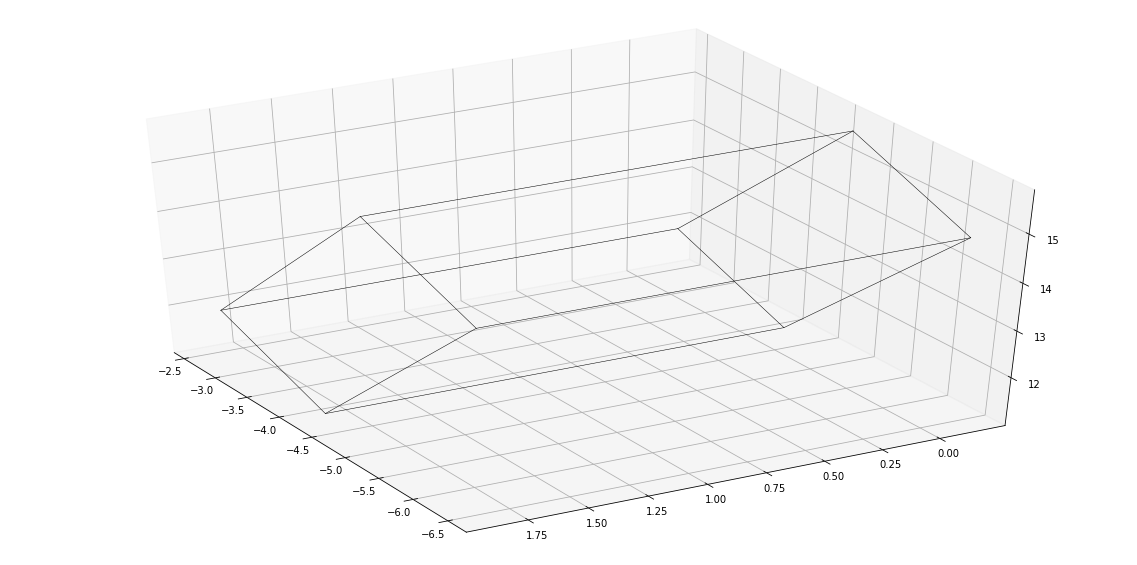

In [12]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, 150)
draw_box(ax, (corners_3d_cam2))

In [13]:
from kitti_util import *

In [14]:
# 代表讀取三個檔案並建立各種矩陣

calib = Calibration('/home/sean/Documents/KITTI/2011_09_26_calib/2011_09_26/', from_video=True) 

# calib這個是別人寫好的套包，例如roject_rect_to_velo()，可以從2號照相機投影到velodyne座標系
# https://github.com/charlesq34/frustum-pointnets
# corners_3d_cam2 是3x8矩陣，但我們要乘上3x3旋轉矩陣，所以要先轉置，再做相乘，為了在顯示出來，我們再做一次轉置
corners_3d_velo = calib.project_rect_to_velo(corners_3d_cam2.T).T
corners_3d_velo

array([[15.12424719, 16.06928938, 12.27779014, 11.33274795, 15.10334837,
        16.04839056, 12.25689133, 11.31184914],
       [ 6.49985556,  4.9406537 ,  2.64287284,  4.2020747 ,  6.47872485,
         4.91952299,  2.62174213,  4.18094399],
       [-1.70710774, -1.71370686, -1.7776097 , -1.77101058,  0.29267156,
         0.28607244,  0.2221696 ,  0.22876872]])

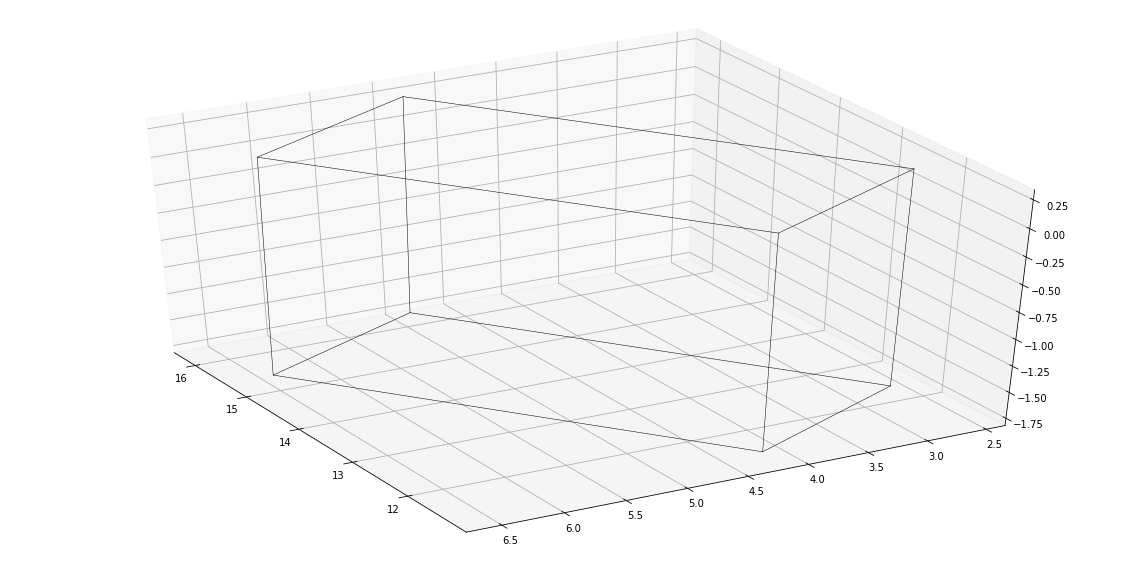

In [15]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, 150)
draw_box(ax, corners_3d_velo)

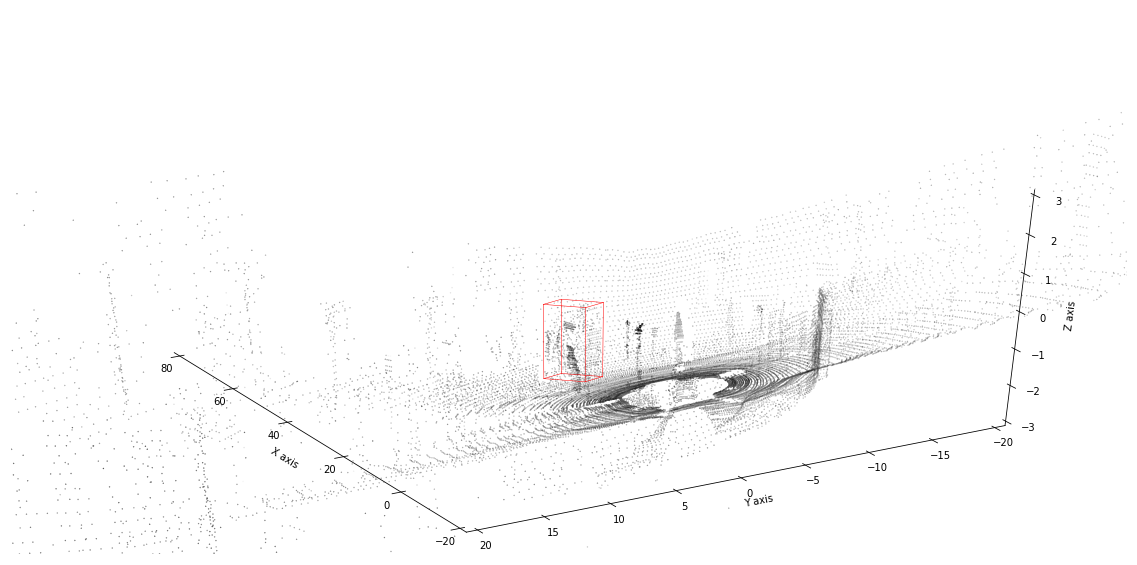

In [16]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, 150)
draw_point_cloud(ax, points[::5])
draw_box(ax, corners_3d_velo, color='r')

In [17]:
corners_3d_velo

array([[15.12424719, 16.06928938, 12.27779014, 11.33274795, 15.10334837,
        16.04839056, 12.25689133, 11.31184914],
       [ 6.49985556,  4.9406537 ,  2.64287284,  4.2020747 ,  6.47872485,
         4.91952299,  2.62174213,  4.18094399],
       [-1.70710774, -1.71370686, -1.7776097 , -1.77101058,  0.29267156,
         0.28607244,  0.2221696 ,  0.22876872]])

In [18]:
ego_car = np.array([[2.15, 0.9, -1.73], [2.15, -0.9, -1.73], [-1.95, -0.9, -1.73], [-1.95, 0.9, -1.73],
                    [2.15, 0.9, -0.23], [2.15, -0.9, -0.23], [-1.95, -0.9, -0.23], [-1.95, 0.9, -0.23]])

In [19]:
ego_car

array([[ 2.15,  0.9 , -1.73],
       [ 2.15, -0.9 , -1.73],
       [-1.95, -0.9 , -1.73],
       [-1.95,  0.9 , -1.73],
       [ 2.15,  0.9 , -0.23],
       [ 2.15, -0.9 , -0.23],
       [-1.95, -0.9 , -0.23],
       [-1.95,  0.9 , -0.23]])

In [20]:
ego_car_T = ego_car.T
corners_3d_velo_T = corners_3d_velo.T

In [21]:
ego_car

array([[ 2.15,  0.9 , -1.73],
       [ 2.15, -0.9 , -1.73],
       [-1.95, -0.9 , -1.73],
       [-1.95,  0.9 , -1.73],
       [ 2.15,  0.9 , -0.23],
       [ 2.15, -0.9 , -0.23],
       [-1.95, -0.9 , -0.23],
       [-1.95,  0.9 , -0.23]])

In [22]:
corners_3d_velo_T

array([[15.12424719,  6.49985556, -1.70710774],
       [16.06928938,  4.9406537 , -1.71370686],
       [12.27779014,  2.64287284, -1.7776097 ],
       [11.33274795,  4.2020747 , -1.77101058],
       [15.10334837,  6.47872485,  0.29267156],
       [16.04839056,  4.91952299,  0.28607244],
       [12.25689133,  2.62174213,  0.2221696 ],
       [11.31184914,  4.18094399,  0.22876872]])

In [23]:
corners_3d_velo = corners_3d_velo.T

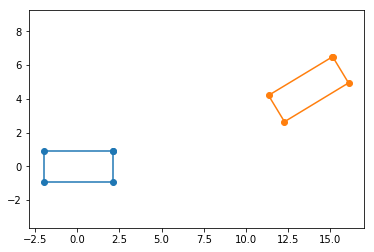

In [24]:
plt.axes().set_aspect('equal', 'datalim')
plt.plot(ego_car[:5, 0],ego_car[:5, 1], '-o') # ???
plt.plot(corners_3d_velo[:5, 0], corners_3d_velo[:5, 1], '-o')

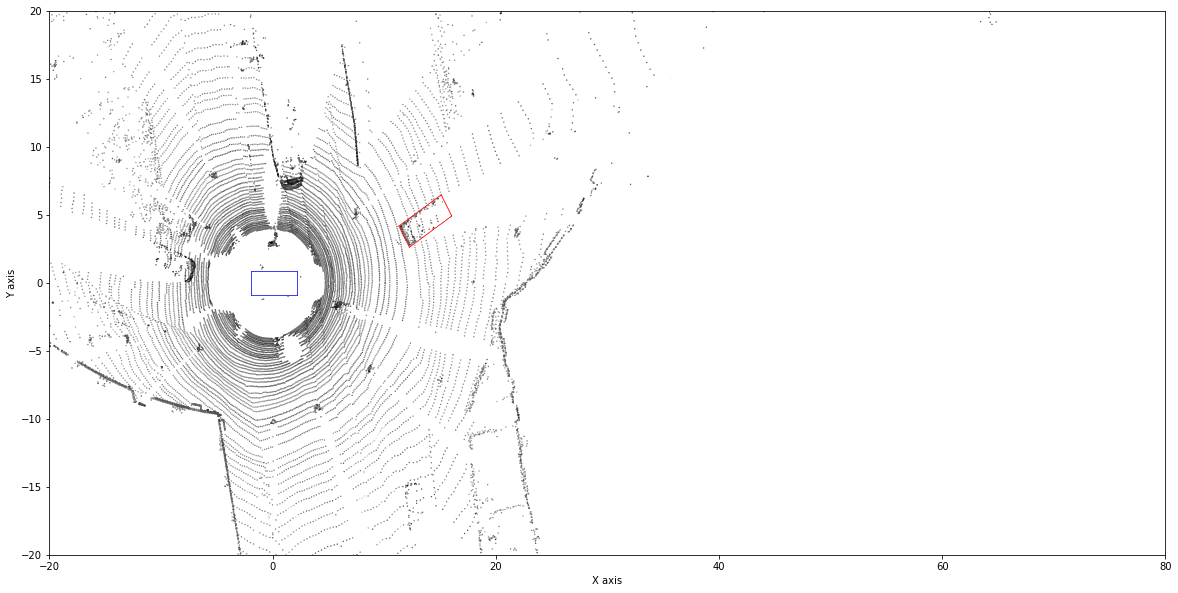

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))
draw_point_cloud(ax, points[::5], axes=[0, 1])
draw_box(ax, corners_3d_velo.T, axes=[0,1], color='r')
draw_box(ax, ego_car_T, axes=[0,1], color='b')

In [26]:
def distance_point_to_segment(P,A,B):
    """
    Calculates the min distance of a point P to a segment AB.
    Returns the point Q in AB on which the min distance is reached.
    """
    AP = P - A
    BP = P - B
    AB = B - A
    if np.dot(AB, AP) >= 0 and np.dot(-AB, BP) >= 0:
        return np.abs(np.cross(AP, AB)) / np.linalg.norm(AB), np.dot(AP, AB) / np.dot(AB, AB) * AB + A
    d_PA = np.linalg.norm(AP)
    d_PB = np.linalg.norm(BP)
    if d_PA < d_PB:
        return d_PA, A
    return d_PB, B

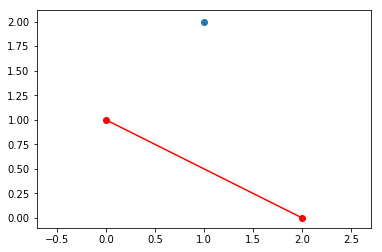

In [27]:
P = np.array([1, 2], dtype=np.float64)
A = np.array([0, 1], dtype=np.float64)
B = np.array([2, 0], dtype=np.float64)

plt.axes().set_aspect('equal', 'datalim')
plt.scatter(P[0], P[1])
plt.plot(zip(A, B)[0], zip(A, B)[1], 'r-o')

In [28]:
distance_point_to_segment(P, A, B)

(1.3416407864998738, array([0.4, 0.8]))

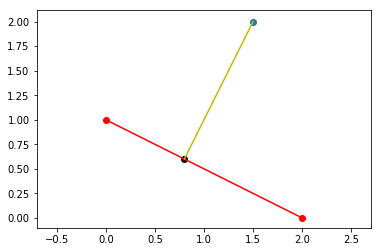

In [29]:
P = np.array([1.5, 2], dtype=np.float64) # 可修改P 點來做測試
A = np.array([0, 1], dtype=np.float64)
B = np.array([2, 0], dtype=np.float64)
(d, Q) = distance_point_to_segment(P, A, B)

plt.axes().set_aspect('equal', 'datalim')
plt.scatter(P[0], P[1])
plt.plot(zip(A, B)[0], zip(A, B)[1], 'r-o')
plt.scatter(Q[0], Q[1], c = 'k')
plt.plot(zip(P, Q)[0], zip(P, Q)[1], 'y-')

In [30]:
def min_distance_cuboids(cub1, cub2):
    """
    Computes the minimum distance between two non-overlapping cuboids (3D) of shape(8, 3).
    They are projected to BEV and the minmum distance of the two rectangles are returned.
    """
    minD = 1e5 # 一開始設一個很大的值
    for i in range(4):
        for j in range(4): # distance_point_to_segment(P, A, B)
            # 設R1 上的P 到R2 上的AB邊長 
            d, Q = distance_point_to_segment(cub1[i, :2], cub2[j, :2], cub2[j+1, :2])
            if d < minD:
                minD = d
                minP = cub1[i, :2]
                minQ = Q
        # 交換 設R2 上的P 到R1 上的AB邊長
        for j in range(4):
            d, Q = distance_point_to_segment(cub2[i, :2], cub1[j, :2], cub1[j+1, :2])
            if d < minD:
                minD = d
                minP = cub2[i, :2]
                minQ = Q
    return minP, minQ, minD

9.758409569343952


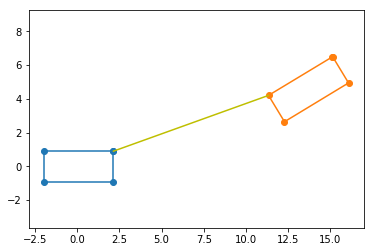

In [31]:
plt.axes().set_aspect('equal', 'datalim')
plt.plot(ego_car[:5, 0], ego_car[:5, 1], '-o')
plt.plot(corners_3d_velo[:5, 0], corners_3d_velo[:5, 1], '-o')
minP, minQ, minD = min_distance_cuboids(ego_car, corners_3d_velo)
plt.plot(zip(minP, minQ)[0], zip(minP, minQ)[1], 'y-')
print(minD)

0.8999999999999999


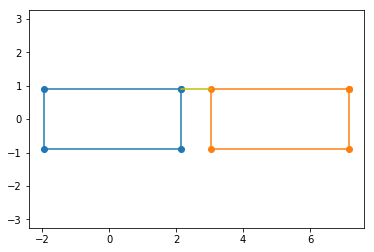

In [32]:
ego_car2 = ego_car.copy()
ego_car2[:, 0] += 5

plt.axes().set_aspect('equal','datalim')
plt.plot(ego_car[:5,0], ego_car[:5,1], '-o')
plt.plot(ego_car2[:5,0], ego_car2[:5,1], '-o')
minP, minQ, minD = min_distance_cuboids(ego_car, ego_car2)
plt.plot(zip(minP, minQ)[0], zip(minP, minQ)[1], 'y-')
print(minD)